# Analysis for Experiment 1

In [39]:
rm(list= ls())

In [40]:
library(dplyr)
library(lme4)
library(lmerTest)
library(BayesFactor)
library(ggplot2)
library(stringr)

In [41]:
# relevant conditions
data.folder <- 'Experiment 1. Connectedness and Common Region'
relevant_conditions <- c('2 masks', '1 mask', '2 masks_connected dots', '1 mask_connected dots')

## Analysis of disappearance duration: at least one target is invisible

In [42]:
## reading imported response data
subjective_state_change<- read.csv(file.path(data.folder, 'Experiment1_SubjectiveStateChange.csv'), sep=';')

subjective_state_change <- subjective_state_change %>%
    # removing irrelevant conditions
    filter(ConditionLabel %in% relevant_conditions) %>%
    
    # extracting presence of individual factors from the condition label
    mutate(MasksN= str_sub(ConditionLabel, 1,1),
           Connected= ifelse(str_sub(ConditionLabel, -4, -1)=='dots', TRUE, FALSE)) %>%

    # making sure that factors are represented as factors
    mutate(MasksN = as.factor(MasksN), 
           Connected = as.factor(Connected)) %>%
 
    # ordering conditions for plotting
    mutate(ConditionLabel= factor(ConditionLabel, levels= relevant_conditions))


In [43]:
disappearance.time <- subjective_state_change %>%
    group_by(ID, MasksN, Connected) %>%
    summarise(time.proportion= sum(Duration[TargetCount<2])/BlockDuration[1])
disappearance.time <- data.frame(disappearance.time)

lm.null <- lme4::lmer(time.proportion ~ 1 + (1|ID), data= disappearance.time, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
lm.connected <- update(lm.masks, .~. + Connected)
lm.interaction <- update(lm.connected, .~. + MasksN*Connected)
anova(lm.null, lm.masks, lm.connected, lm.interaction)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-92.18295,-85.89991,49.09147,-98.18295,NA,NA,NA
lm.masks,4,-90.44565,-82.06827,49.22282,-98.44565,0.2626977,1,6.082729e-01
lm.connected,5,-116.74402,-106.27230,63.37201,-126.74402,28.2983795,1,1.039830e-07
lm.interaction,6,-114.88571,-102.31965,63.44286,-126.88571,0.1416895,1,7.066071e-01


In [44]:
# seeding random generator to ensure reproducable Bayesian MCMC results
set.seed(111122017)
duration.bayes <- sort(anovaBF(time.proportion ~ MasksN + Connected + ID, data= disappearance.time, whichRandom = 'ID'), 
                       decreasing = TRUE)
duration.bayes

Bayes factor analysis
--------------
[1] Connected + ID                             : 55246.29  ±0.95%
[2] MasksN + Connected + ID                    : 17209.92  ±1.23%
[3] MasksN + Connected + MasksN:Connected + ID : 6314.714  ±3.56%
[4] MasksN + ID                                : 0.2899874 ±1.16%

Against denominator:
  time.proportion ~ ID 
---
Bayes factor type: BFlinearModel, JZS


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: time.proportion ~ ConditionLabel + (1 | ID)
   Data: time.per.condition.lmer

REML criterion at convergence: -103.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.49540 -0.60363 -0.07314  0.33840  2.54055 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.007655 0.08749 
 Residual             0.004537 0.06736 
Number of obs: 60, groups:  ID, 15

Fixed effects:
                                     Estimate Std. Error       df t value
(Intercept)                           0.21883    0.02851 25.66000   7.676
ConditionLabel1 mask                  0.01816    0.02459 42.00000   0.738
ConditionLabel2 masks_connected dots -0.09929    0.02459 42.00000  -4.037
ConditionLabel1 mask_connected dots  -0.09379    0.02459 42.00000  -3.814
                                     Pr(>|t|)    
(Intercept)                          4.16e-08 ***

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.21883424,0.02850897,25.65678,7.6759791,4.161203e-08,0.8346541
0.01815830,0.02459483,42.00015,0.7382975,4.644393e-01,0.1131894
-0.09929279,0.02459483,42.00015,-4.0371402,2.245530e-04,0.5287429
-0.09379315,0.02459483,42.00015,-3.8135309,4.424386e-04,0.5071509


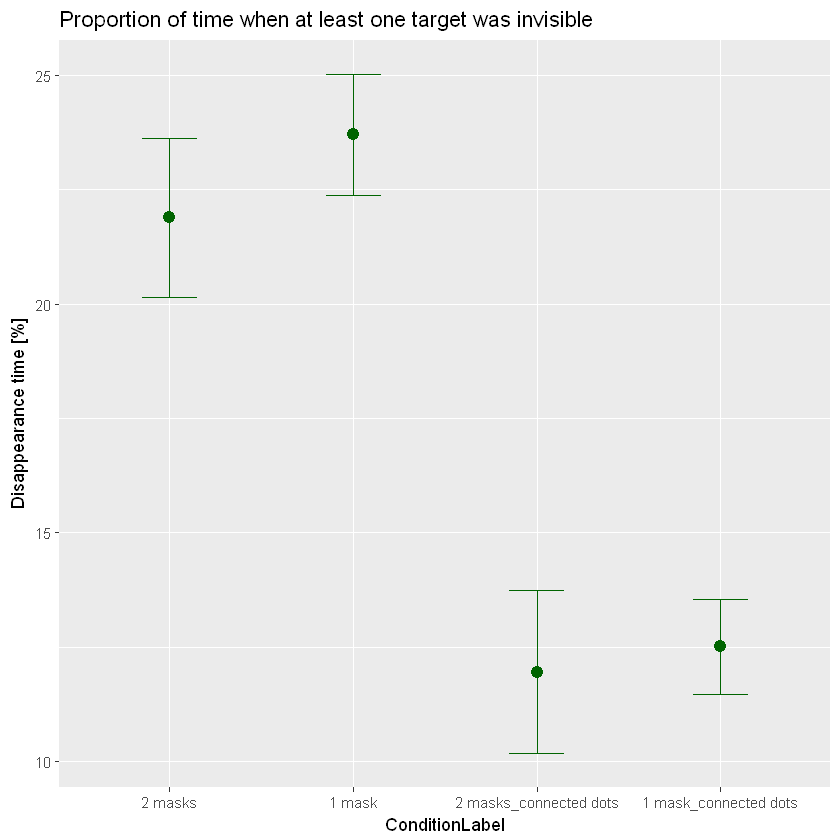

In [45]:
# averages per group
time.per.condition.plot <- subjective_state_change %>%

    # computing observer proportion per condition
    group_by(ID, ConditionLabel) %>%
    summarise(time.proportion= sum(Duration[TargetCount<2])/BlockDuration[1]) %>%

    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(time.proportion)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(time.proportion)) %>%
    mutate(time.adjusted= time.proportion - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(ConditionLabel) %>%
    summarise(time.avg= mean(time.adjusted*100),
              time.serr= sd(time.adjusted*100)/sqrt(n()))

# averages per condition x observer for linear mixed models
time.per.condition.lmer <- subjective_state_change %>%
    # computing observer proportion per condition
    group_by(ID, ConditionLabel) %>%
    summarise(time.proportion= sum(Duration[TargetCount<2])/BlockDuration[1])

# comparison to the baseline condition (M3)
duration.lmer <- summary(lmerTest::lmer(time.proportion ~ ConditionLabel + (1|ID), data= time.per.condition.lmer))
duration.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(duration.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

# plot
time.plot <- ggplot(data= time.per.condition.plot, aes(x= ConditionLabel, y= time.avg, ymin= time.avg-time.serr, ymax= time.avg+time.serr))+
    geom_errorbar(color= 'darkgreen', width=0.3)+
    geom_point(color= 'darkgreen', size= 3) + 
    ylab('Disappearance time [%]') +
    ggtitle('Proportion of time when at least one target was invisible')
print(time.plot)

## Simultaneity of appearance and disappearance events

In [46]:
results <- read.csv(file.path(data.folder, 'Experiment1_Simultaneity.csv'), sep=';')

results <- results %>%
    # removing irrelevant conditions
    filter(ConditionLabel %in% relevant_conditions) %>%

    # extracting presence of individual factors from the condition label
    mutate(MasksN= str_sub(ConditionLabel, 1,1),
           Connected= ifelse(str_sub(ConditionLabel, -4, -1)=='dots', TRUE, FALSE)) %>%

    # making sure that factors are represented as factors
    mutate(MasksN = as.factor(MasksN), 
           Connected = as.factor(Connected), 
           Event= as.factor(Event)) %>%
 
    # ordering conditions for plotting
    mutate(ConditionLabel= factor(ConditionLabel, levels= relevant_conditions))

In [47]:
sim.events <- results %>%
    group_by(ID, Connected, MasksN, Event, ConditionLabel) %>%
    summarise(sim.proportion= 100*sum(SimCount>1)/n())
sim.events <- data.frame(sim.events)

lm.null <- lme4::lmer(sim.proportion ~ 1 + (1|ID), data= sim.events, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
lm.Connected <- update(lm.masks, .~. + Connected)
lm.event <- update(lm.Connected, .~. + Event)
lm.mask.connected <- update(lm.event, .~. + MasksN*Connected)
lm.mask.event <- update(lm.mask.connected, .~. + MasksN*Event)
lm.connected.event <- update(lm.mask.event, .~. + Connected*Event)
lm.full.interaction <- update(lm.connected.event, .~. + MasksN*Connected*Event)
anova(lm.null, lm.masks, lm.Connected, lm.event, lm.mask.connected, lm.mask.event, lm.connected.event, lm.full.interaction)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,1022.4686,1030.6772,-508.2343,1016.4686,NA,NA,NA
lm.masks,4,987.6745,998.6193,-489.8373,979.6745,36.79408448,1,1.312880e-09
lm.Connected,5,988.8325,1002.5135,-489.4163,978.8325,0.84199111,1,3.588279e-01
lm.event,6,986.7842,1003.2014,-487.3921,974.7842,4.04838218,1,4.421370e-02
lm.mask.connected,7,988.7102,1007.8636,-487.3551,974.7102,0.07398549,1,7.856199e-01
lm.mask.event,8,990.6401,1012.5297,-487.3201,974.6401,0.07003732,1,7.912825e-01
lm.connected.event,9,992.6092,1017.2350,-487.3046,974.6092,0.03094939,1,8.603533e-01
lm.full.interaction,10,994.4923,1021.8543,-487.2462,974.4923,0.11688062,1,7.324426e-01


In [48]:
set.seed(211122017)
sim.bayes <- sort(anovaBF(sim.proportion ~ MasksN+Connected+Event+ID, data= data.frame(sim.events), whichRandom = 'ID'), decreasing = TRUE)
sim.bayes

Bayes factor analysis
--------------
[1] MasksN + Event + ID                                                                                           : 5671476   ±2.97%
[2] MasksN + ID                                                                                                   : 4800470   ±1.33%
[3] Connected + MasksN + Event + ID                                                                               : 1574023   ±1.98%
[4] MasksN + Event + MasksN:Event + ID                                                                            : 1464969   ±2.56%
[5] Connected + MasksN + ID                                                                                       : 1384103   ±1.62%
[6] Connected + MasksN + Event + Connected:Event + ID                                                             : 463136.6  ±7.22%
[7] Connected + MasksN + Connected:MasksN + Event + ID                                                            : 447673.9  ±3.5%
[8] Connected + MasksN + Event + 

As analysis above suggested a significant effect of the event type, looking disappearances (0) and reappearances (1) separately

### Disappearances

In [49]:
sim.disappearance <- sim.events %>%
    filter(Event==0)

lm.null <- lme4::lmer(sim.proportion ~ 1 + (1|ID), data= sim.disappearance, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
lm.connected <- update(lm.masks, .~. + Connected)
lm.mask.connected <- update(lm.connected, .~. + MasksN*Connected)
anova(lm.null, lm.masks, lm.connected, lm.mask.connected)

set.seed(311122017)
sim.bayes <- sort(anovaBF(sim.proportion ~ MasksN+Connected+ID, data= data.frame(sim.disappearance), whichRandom = 'ID'), decreasing = TRUE)
sim.bayes

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,524.5724,530.7016,-259.2862,518.5724,NA,NA,NA
lm.masks,4,508.2249,516.3972,-250.1125,500.2249,18.3474685,1,1.840634e-05
lm.connected,5,509.8865,520.1018,-249.9433,499.8865,0.3384236,1,5.607406e-01
lm.mask.connected,6,511.7582,524.0165,-249.8791,499.7582,0.1283027,1,7.201984e-01


Bayes factor analysis
--------------
[1] MasksN + ID                                : 691.921   ±3.05%
[2] Connected + MasksN + ID                    : 208.2029  ±1.45%
[3] Connected + MasksN + Connected:MasksN + ID : 73.06162  ±2.53%
[4] Connected + ID                             : 0.3268039 ±1.23%

Against denominator:
  sim.proportion ~ ID 
---
Bayes factor type: BFlinearModel, JZS


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: sim.proportion ~ ConditionLabel + (1 | ID)
   Data: sim.disappearance

REML criterion at convergence: 479.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.24797 -0.64125  0.05682  0.44755  2.52546 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 372.4    19.30   
 Residual             244.7    15.64   
Number of obs: 57, groups:  ID, 15

Fixed effects:
                                     Estimate Std. Error     df t value
(Intercept)                            27.636      6.414 26.180   4.309
ConditionLabel1 mask                   17.888      5.712 38.960   3.132
ConditionLabel2 masks_connected dots    0.798      6.149 39.440   0.130
ConditionLabel1 mask_connected dots    21.586      5.712 38.960   3.779
                                     Pr(>|t|)    
(Intercept)                          0.000206 ***
ConditionLabel1 m

Estimate,Std.Error,df,t.value,p.value,R.sqr
27.6361504,6.414040,26.17711,4.3086963,0.0002057154,0.64415191
17.8882380,5.711582,38.95529,3.1319236,0.0032900267,0.44849795
0.7980086,6.149391,39.44228,0.1297703,0.8974076819,0.02065864
21.5856910,5.711582,38.95529,3.7792842,0.0005271502,0.51796159


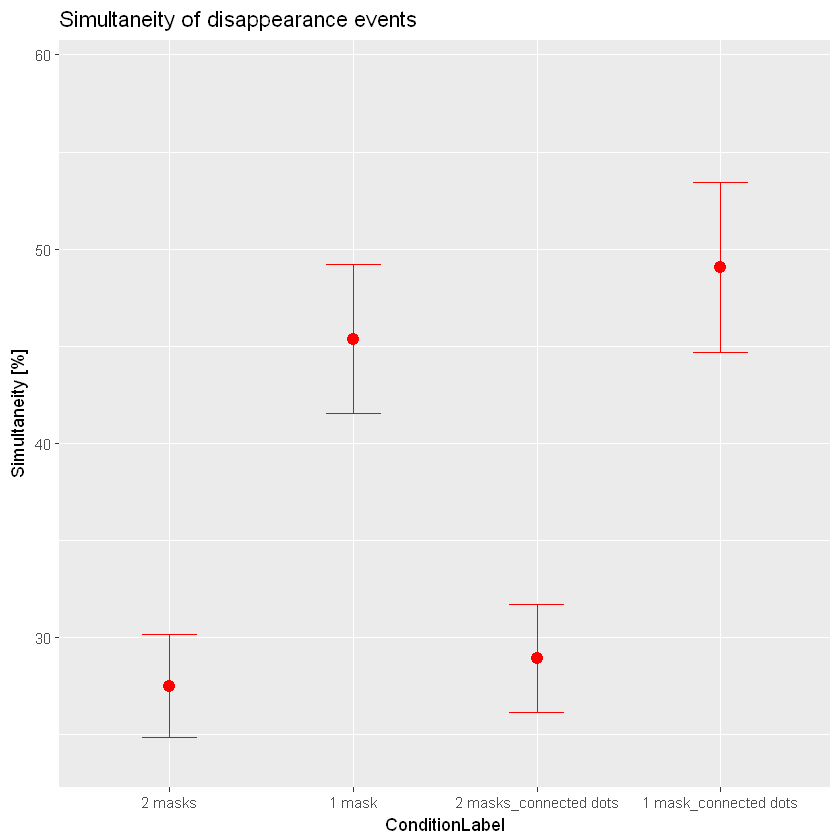

In [59]:
# averages per group
sim.per.condition.plot <- sim.disappearance %>%
    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(sim.proportion)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(sim.proportion)) %>%
    mutate(sim.adjusted= sim.proportion - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(ConditionLabel) %>%
    summarise(sim.avg= mean(sim.adjusted),
              sim.serr= sd(sim.adjusted)/sqrt(n()))

# comparison to the baseline condition (M3)
sim.lmer <- summary(lmerTest::lmer(sim.proportion ~ ConditionLabel + (1|ID), data= sim.disappearance))
sim.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(sim.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

# plot
sim.plot <- ggplot(data= sim.per.condition.plot, aes(x= ConditionLabel, y= sim.avg, ymin= sim.avg-sim.serr, ymax= sim.avg+sim.serr))+
    geom_errorbar(color= 'red', width=0.3)+
    geom_point(color= 'red', size= 3) + 
    ylab('Simultaneity [%]') +
    ylim(24, 59) + 
    ggtitle('Simultaneity of disappearance events')
print(sim.plot)

### Reappearances

In [51]:
sim.reappearance <- sim.events %>%
    filter(Event==1)

lm.null <- lme4::lmer(sim.proportion ~ 1 + (1|ID), data= sim.reappearance, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
lm.connected <- update(lm.masks, .~. + Connected)
lm.mask.connected <- update(lm.connected, .~. + MasksN*Connected)
anova(lm.null, lm.masks, lm.connected, lm.mask.connected)

set.seed(411122017)
sim.bayes <- sort(anovaBF(sim.proportion ~ MasksN+Connected+ID, data= data.frame(sim.reappearance), whichRandom = 'ID'), decreasing = TRUE)
sim.bayes

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,524.0517,530.1809,-259.0259,518.0517,NA,NA,NA
lm.masks,4,509.7276,517.8998,-250.8638,501.7276,1.632415e+01,1,5.337927e-05
lm.connected,5,511.2381,521.4534,-250.6191,501.2381,4.894435e-01,1,4.841757e-01
lm.mask.connected,6,513.2381,525.4964,-250.6190,501.2381,3.679103e-05,1,9.951604e-01


Bayes factor analysis
--------------
[1] MasksN + ID                                : 274.2803  ±0.83%
[2] Connected + MasksN + ID                    : 92.78982  ±2.99%
[3] Connected + MasksN + Connected:MasksN + ID : 33.42646  ±4.21%
[4] Connected + ID                             : 0.3474284 ±0.92%

Against denominator:
  sim.proportion ~ ID 
---
Bayes factor type: BFlinearModel, JZS


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: sim.proportion ~ ConditionLabel + (1 | ID)
   Data: sim.reappearance

REML criterion at convergence: 480.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.24585 -0.69727  0.06446  0.41513  2.40667 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 377.3    19.42   
 Residual             252.0    15.88   
Number of obs: 57, groups:  ID, 15

Fixed effects:
                                     Estimate Std. Error     df t value
(Intercept)                            32.654      6.477 26.340   5.041
ConditionLabel1 mask                   18.152      5.797 38.940   3.131
ConditionLabel2 masks_connected dots    2.845      6.241 39.440   0.456
ConditionLabel1 mask_connected dots    21.047      5.797 38.940   3.631
                                     Pr(>|t|)    
(Intercept)                          2.91e-05 ***
ConditionLabel1 ma

Estimate,Std.Error,df,t.value,p.value,R.sqr
32.654487,6.477446,26.33633,5.0412599,2.912214e-05,0.70077928
18.152460,5.796992,38.94202,3.1313586,3.295694e-03,0.44849432
2.845265,6.241072,39.43575,0.4558937,6.509670e-01,0.07240643
21.046824,5.796992,38.94202,3.6306460,8.126877e-04,0.50288264


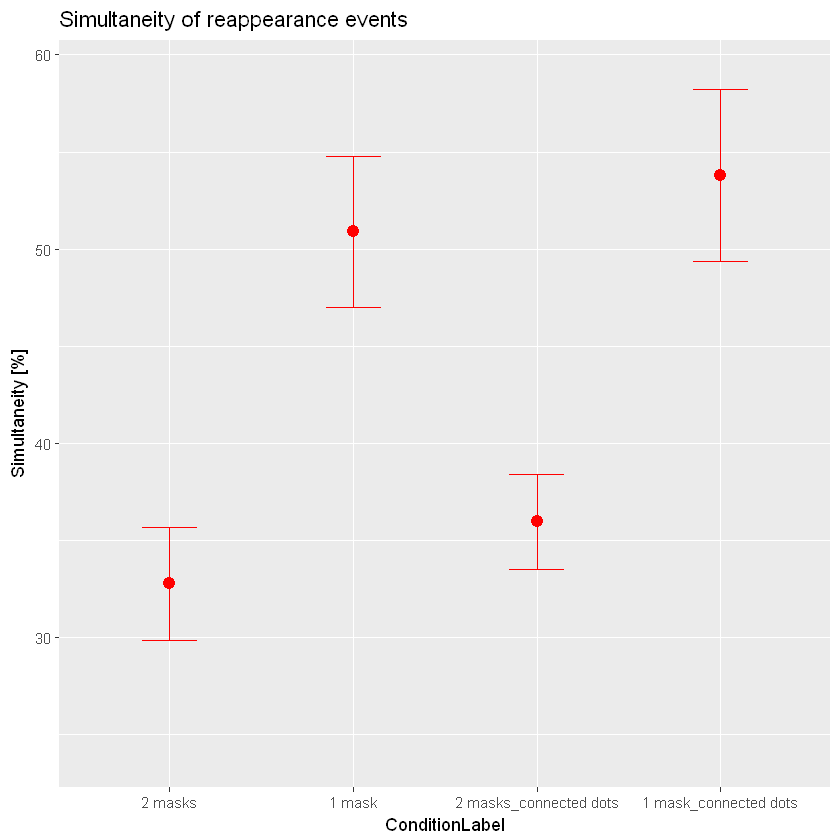

In [60]:
# averages per group
sim.per.condition.plot <- sim.reappearance %>%
    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(sim.proportion)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(sim.proportion)) %>%
    mutate(sim.adjusted= sim.proportion - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(ConditionLabel) %>%
    summarise(sim.avg= mean(sim.adjusted),
              sim.serr= sd(sim.adjusted)/sqrt(n()))

# comparison to the baseline condition (M3)
sim.lmer <- summary(lmerTest::lmer(sim.proportion ~ ConditionLabel + (1|ID), data= sim.reappearance))
sim.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(sim.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

# plot
sim.plot <- ggplot(data= sim.per.condition.plot, aes(x= ConditionLabel, y= sim.avg, ymin= sim.avg-sim.serr, ymax= sim.avg+sim.serr))+
    geom_errorbar(color= 'red', width=0.3)+
    geom_point(color= 'red', size= 3) + 
    ylab('Simultaneity [%]') +
    ylim(24, 59) + 
    ggtitle('Simultaneity of reappearance events')
print(sim.plot)

## Analysis of disappearance duration: average disappearance across all targets

In [53]:
responses <- read.csv(file.path(data.folder, 'Experiment1_Response.csv'), sep=';')

responses <- responses %>%
    # removing irrelevant conditions
    filter(ConditionLabel %in% relevant_conditions) %>%

    # extracting presence of individual factors from the condition label
    mutate(MasksN= str_sub(ConditionLabel, 1,1),
           Connected= ifelse(str_sub(ConditionLabel, -4, -1)=='dots', TRUE, FALSE)) %>%

    # making sure that factors are represented as factors
    mutate(MasksN = as.factor(MasksN), 
           Connected = as.factor(Connected)) %>%
 
    # ordering conditions for plotting
    mutate(ConditionLabel= factor(ConditionLabel, levels= relevant_conditions))

# computing block duration 
block.duration <- responses %>%
    filter(EventLabel %in% c('Block start', 'Block end')) %>%
    group_by(ID, Block) %>%
    summarise(Block.Duration= Time[2]-Time[1])
responses <- responses %>% 
    left_join(block.duration, by = c('ID', 'Block'))

# computing disappearance time
disappearance.across.targets <- responses %>% 
    # only for real target events
    filter(Target %in% c(0, 1)) %>% 

    # computing disappearance for individual targets
    group_by(ID, Block, MasksN, Connected, Target, ConditionLabel) %>%
    summarise(disapp.prop = 100*sum(Time[EventLabel=='Released']-Time[EventLabel=='Pressed'])/Block.Duration[1]) %>%
  
    # average across all of them
    group_by(ID, Connected, MasksN, ConditionLabel) %>%
    summarise(time.proportion = mean(disapp.prop))
disappearance.across.targets <- data.frame(disappearance.across.targets)

In [54]:
lm.null <- lme4::lmer(time.proportion ~ 1 + (1|ID), data= disappearance.across.targets, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
lm.connected <- update(lm.masks, .~. + Connected)
lm.interaction <- update(lm.connected, .~. + MasksN*Connected)
anova(lm.null, lm.masks, lm.connected, lm.interaction)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,404.7365,410.8656,-199.3682,398.7365,NA,NA,NA
lm.masks,4,406.6856,414.8578,-199.3428,398.6856,0.05089644,1,8.215107e-01
lm.connected,5,391.6285,401.8437,-190.8142,381.6285,17.05711099,1,3.627229e-05
lm.interaction,6,393.3870,405.6453,-190.6935,381.3870,0.24147834,1,6.231404e-01


In [55]:
set.seed(511122017)
duration.bayes <- sort(anovaBF(time.proportion ~ MasksN + Connected + ID, data= disappearance.across.targets, whichRandom = 'ID'), 
                       decreasing = TRUE)
duration.bayes

Bayes factor analysis
--------------
[1] Connected + ID                             : 413.149   ±8.37%
[2] Connected + MasksN + ID                    : 130.7431  ±12.16%
[3] Connected + MasksN + Connected:MasksN + ID : 44.69304  ±3.52%
[4] MasksN + ID                                : 0.2726977 ±1.22%

Against denominator:
  time.proportion ~ ID 
---
Bayes factor type: BFlinearModel, JZS


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: time.proportion ~ ConditionLabel + (1 | ID)
   Data: disappearance.across.targets

REML criterion at convergence: 369.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.60158 -0.56065 -0.03577  0.41339  2.68133 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 32.90    5.736   
 Residual             33.77    5.811   
Number of obs: 57, groups:  ID, 15

Fixed effects:
                                     Estimate Std. Error     df t value
(Intercept)                            15.371      2.108 31.330   7.291
ConditionLabel1 mask                    1.640      2.122 38.880   0.773
ConditionLabel2 masks_connected dots   -6.163      2.281 39.560  -2.701
ConditionLabel1 mask_connected dots    -6.001      2.122 38.880  -2.828
                                     Pr(>|t|)    
(Intercept)                          3.12e-08 ***
Condi

Estimate,Std.Error,df,t.value,p.value,R.sqr
15.370725,2.108155,31.32668,7.2910773,3.124830e-08,0.7932281
1.639835,2.121880,38.87702,0.7728216,4.443013e-01,0.1230048
-6.162625,2.281435,39.56169,-2.7012051,1.012084e-02,0.3946070
-6.001386,2.121880,38.87702,-2.8283337,7.360145e-03,0.4130980


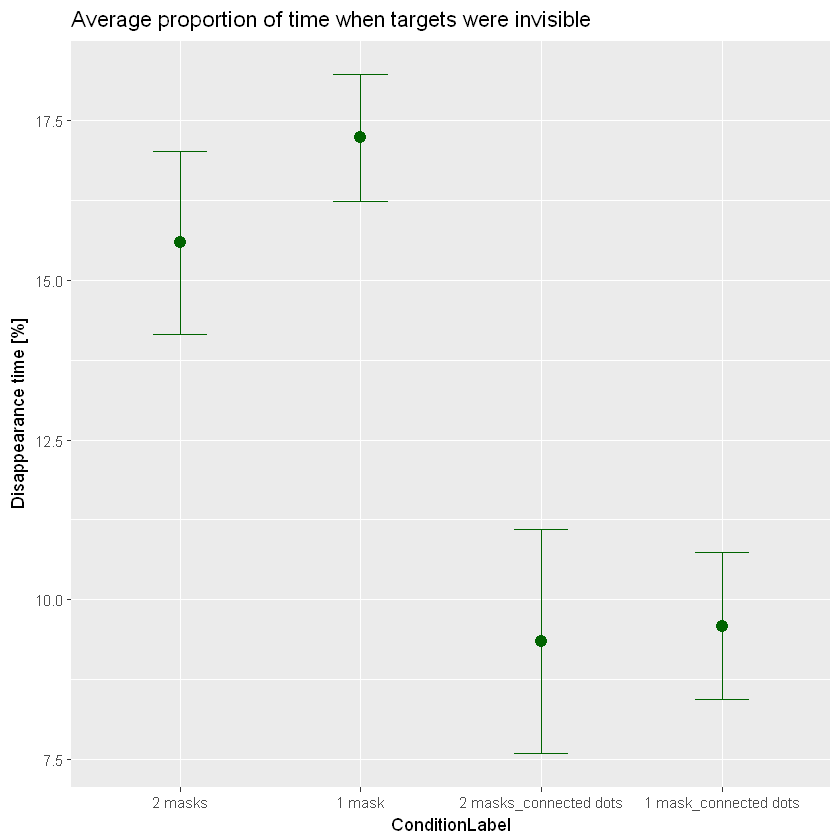

In [57]:
# averages per group
time.per.condition.plot <- disappearance.across.targets %>%
    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(time.proportion)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(time.proportion)) %>%
    mutate(time.adjusted= time.proportion - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(ConditionLabel) %>%
    summarise(time.avg= mean(time.adjusted),
              time.serr= sd(time.adjusted)/sqrt(n()))

# comparison to the baseline condition (M3)
duration.lmer <- summary(lmerTest::lmer(time.proportion ~ ConditionLabel + (1|ID), data= disappearance.across.targets))
duration.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(duration.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

# plot
time.plot <- ggplot(data= time.per.condition.plot, aes(x= ConditionLabel, y= time.avg, ymin= time.avg-time.serr, ymax= time.avg+time.serr))+
    geom_errorbar(color= 'darkgreen', width=0.3)+
    geom_point(color= 'darkgreen', size= 3) + 
    ylab('Disappearance time [%]') +
    ggtitle('Average proportion of time when targets were invisible')
print(time.plot)